In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score


np.random.seed(42)

In [2]:
# Gaussian Mixture Model Parameters
# Pis
pi = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Means
means = [
    [-10.0, 0.0],
    [0.0, -10.0],
    [10.0, 0.0],
    [0.0, 10.0],
    [-5.0, 4.5],
    [5.0, 4.5],
    [0.0, -0.5],
    [0.0, -7.5],
    [-7.0, -5.5],
    [7.0, -5.5],
]

# Sigmas
covs = [
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[3.0, 0.0], [0.0, 0.1]],
    [[1.0, 0.0], [0.0, 1.0]],
    [[0.1, 0.0], [0.0, 3.0]],
    [[4.0, 0.0], [0.0, 0.1]],
    [[0.5500000000000002, -0.45], [-0.45, 0.5499999999999999]],
    [[0.5500000000000002, 0.45], [0.45, 0.5499999999999999]],
]

In [3]:
# Generate synthetic data from the GMM
def generate_data(n_samples=1000):
    data = []
    labels = []
    for i, (mean, cov) in enumerate(zip(means, covs)):
        n = int(n_samples * pi[i])
        samples = np.random.multivariate_normal(mean, cov, n)
        data.append(samples)
        labels.extend([i] * n)
    return np.vstack(data), np.array(labels)


data, labels = generate_data()

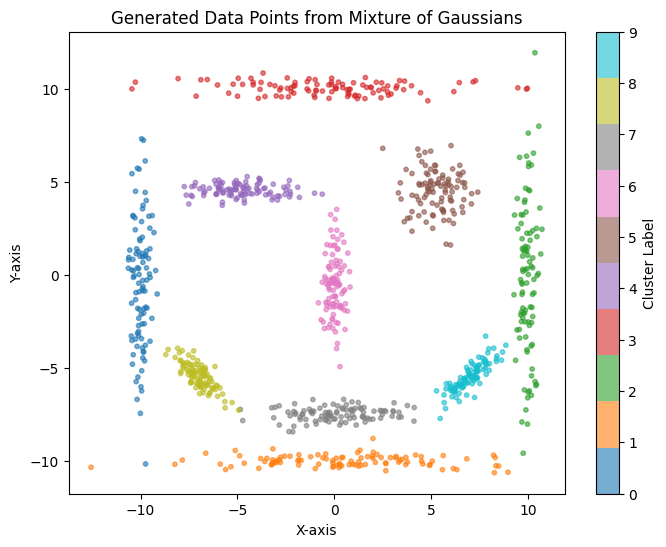

In [4]:
# Visualize the true distribution
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, c=labels, cmap="tab10", s=10)
plt.title("Generated Data Points from Mixture of Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Cluster Label")

In [5]:
def print_ARI(labels_true, labels_pred):
    ari = adjusted_rand_score(labels_true, labels_pred)
    print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.6359


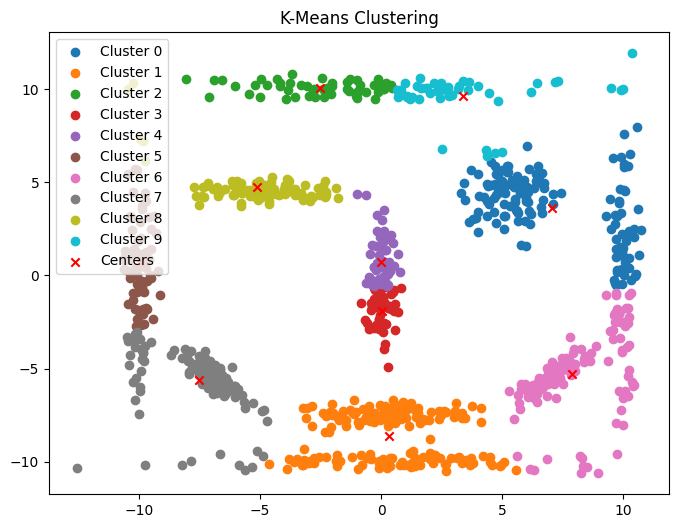

In [6]:
# 1. K-Means Clustering
def run_kmeans(data, n_clusters=3):
    predictions = np.random.randint(0, n_clusters, size=len(data))
    centers = np.random.rand(n_clusters, data.shape[1])

    # Init clusters list
    clusters = [[] for _ in range(n_clusters)]

    # Loop until convergence
    converged = False
    while not converged:
        # clear clusters
        clusters = [[] for _ in range(n_clusters)]

        # Assign each point to the closest center
        for i, point in enumerate(data):
            distances = [np.linalg.norm(point - center) for center in centers]
            cluster = np.argmin(distances)
            clusters[cluster].append(point)
            predictions[i] = cluster

        # Update centers
        new_centers = np.array([
            np.mean(cluster, axis=0) if len(cluster) > 0 else centers[i] for i, cluster in enumerate(clusters)
            ])
        
        converged = np.allclose(new_centers, centers, atol=1e-8)
        centers = new_centers


    return predictions, centers
        

n_clusters = len(pi)
kmeans_predictions, centers = run_kmeans(data, n_clusters)

# Print ARI
print_ARI(labels, kmeans_predictions)

# Plot K-Means Results
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(
        data[kmeans_predictions == i, 0], data[kmeans_predictions == i, 1], label=f"Cluster {i}"
    )
plt.scatter(centers[:, 0], centers[:, 1], c="red", marker="x", label="Centers")
plt.legend()
plt.title("K-Means Clustering")
plt.show()

In [7]:
# 2. Gibbs Sampling for Clustering
import numpy as np

def gaussian_likelihood(x, mean, cov):
    diff = x - mean
    exp_term = np.exp(-0.5 * np.dot(diff.T, np.linalg.solve(cov, diff)))
    norm_const = np.sqrt((2 * np.pi) ** len(mean) * np.linalg.det(cov))
    return exp_term / norm_const

def gibbs_sampling(data, n_clusters=3, n_samples=500, burn_in=200):
    n_points, dim = data.shape
    
    # Initialize cluster assignments randomly
    cluster_assignments = np.random.choice(n_clusters, n_points)
    
    # Initialize cluster parameters randomly
    cluster_means = np.random.randn(n_clusters, dim)
    cluster_covs = np.array([np.eye(dim)] * n_clusters)
    
    # Iteratively sample
    for iteration in range(n_samples + burn_in):
        # Step 1: Sample cluster assignments
        for i in range(n_points):
            probs = []
            for k in range(n_clusters):
                prior = 1.0 / n_clusters  # Uniform prior
                likelihood = gaussian_likelihood(data[i], cluster_means[k], cluster_covs[k])
                probs.append(prior * likelihood)
            probs = np.array(probs) / np.sum(probs)  # Normalize probabilities
            cluster_assignments[i] = np.random.choice(n_clusters, p=probs)
        
        # Step 2: Update cluster parameters
        for k in range(n_clusters):
            points_in_cluster = data[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                cluster_means[k] = np.mean(points_in_cluster, axis=0)
                cluster_covs[k] = np.cov(points_in_cluster.T) if len(points_in_cluster) > 1 else np.eye(dim)
    
    return cluster_assignments

gibbs_predictions = gibbs_sampling(data, n_clusters)

# Plot Gibbs Sampling Results
plt.figure(figsize=(8, 6))
for i in range(len(pi)):
    plt.scatter(
        data[gibbs_predictions == i, 0],
        data[gibbs_predictions == i, 1],
        label=f"Cluster {i}",
    )
plt.title("Gibbs Sampling Clustering")
plt.legend()

KeyboardInterrupt: 

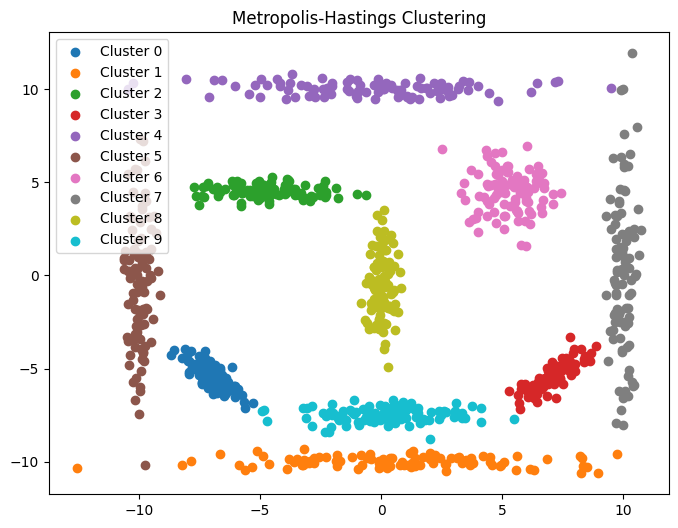

In [ ]:
def gaussian_likelihood(x, mean, cov):
    diff = x - mean
    exp_term = np.exp(-0.5 * np.dot(diff.T, np.linalg.solve(cov, diff)))
    norm_const = np.sqrt((2 * np.pi) ** len(mean) * np.linalg.det(cov))
    return exp_term / norm_const

# Metropolis-Hastings function for clustering
def metropolis_hastings(data, n_clusters=3, proposal_std=1.0, n_samples=500, burn_in=200):
    n_points, dim = data.shape

    # Initialize cluster assignments randomly
    cluster_assignments = np.random.choice(n_clusters, n_points)

    # Initialize cluster parameters
    cluster_means = np.random.randn(n_clusters, dim)
    cluster_covs = np.array([np.eye(dim)] * n_clusters)

    # Function to compute the posterior probability of a cluster assignment
    def posterior(cluster_idx, point_idx):
        mean = cluster_means[cluster_idx]
        cov = cluster_covs[cluster_idx]
        prior = 1.0 / n_clusters  # Uniform prior
        likelihood = gaussian_likelihood(data[point_idx], mean, cov)
        return prior * likelihood

    # Sampling process
    for iteration in range(n_samples + burn_in):
        for i in range(n_points):
            current_cluster = cluster_assignments[i]

            # Propose a new cluster assignment
            proposed_cluster = np.random.randint(0, n_clusters)

            # Compute acceptance ratio
            current_posterior = posterior(current_cluster, i)
            proposed_posterior = posterior(proposed_cluster, i)
            acceptance_ratio = min(1, proposed_posterior / current_posterior)

            # Accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                cluster_assignments[i] = proposed_cluster

        # Update cluster parameters after each iteration
        for k in range(n_clusters):
            points_in_cluster = data[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                cluster_means[k] = np.mean(points_in_cluster, axis=0)
                cluster_covs[k] = np.cov(points_in_cluster.T) if len(points_in_cluster) > 1 else np.eye(dim)

    return cluster_assignments


mh_predictions = metropolis_hastings(data, n_clusters)

# Plot Metropolis-Hastings Results
plt.figure(figsize=(8, 6))
for i in range(len(pi)):
    plt.scatter(
        data[mh_predictions == i, 0], data[mh_predictions == i, 1], label=f"Cluster {i}"
    )
plt.title("Metropolis-Hastings Clustering")
plt.legend()
plt.show()

In [ ]:
# Evaluate Clustering Results

# Assuming true_labels is a numpy array containing the true labels of the data points
# and kmeans_predictions, gibbs_predictions, mh_predictions are the predicted labels

# Calculate ARI for each clustering method
kmeans_ari = adjusted_rand_score(labels, kmeans_predictions)
gibbs_ari = adjusted_rand_score(labels, gibbs_predictions)
mh_ari = adjusted_rand_score(labels, mh_predictions)

# Print the ARI results
print("Adjusted Rand Index of Clustering Methods:")
print(f"K-Means ARI: {kmeans_ari:.2f}")
print(f"Gibbs Sampling ARI: {gibbs_ari:.2f}")
print(f"Metropolis-Hastings ARI: {mh_ari:.2f}")


Adjusted Rand Index of Clustering Methods:
K-Means ARI: 0.64
Gibbs Sampling ARI: 0.98
Metropolis-Hastings ARI: 0.99


In [ ]:
# Compare Results
print("Comparison of Clustering Results:")
print("K-Means Predictions:", np.bincount(kmeans_predictions))
print("Gibbs Sampling Predictions:", np.bincount(gibbs_predictions))
print("Metropolis-Hastings Predictions:", np.bincount(mh_predictions))

Comparison of Clustering Results:
K-Means Predictions: [151 179  56  46  56  72 153 136 103  48]
Gibbs Sampling Predictions: [ 99  97 101 103 100 101 100  99 100 100]
Metropolis-Hastings Predictions: [ 99 100 100  99  98 100 100 101 100 103]
